In [1]:
!nvidia-smi

Tue Sep 26 20:21:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   28C    P8     9W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Librerias

In [2]:
import os
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from unidecode import unidecode
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset

from google.cloud.bigquery import Client
from google.oauth2.service_account import Credentials


In [3]:
# Opciones
plt.style.use("ggplot")
pd.set_option("display.max_colwidth", None)

### Variables

In [5]:
# BigQuery Variables
SERVICE_ACC_FILE="valid-dragon-397303-a396a9a99124.json"
PROJECT_ID="valid-dragon-397303"

# Seed
SEED=1399

# Cliente BQ
CREDENTIALS = Credentials.from_service_account_file(SERVICE_ACC_FILE)
client = Client(project=PROJECT_ID, credentials=CREDENTIALS)

### Conjunto de Datos

#### Cargar datos

In [6]:
%%time
# Se traen los datos desde BigQuery
brands = ["Nintendo", "Electronic Arts", "Sony", "Microsoft", "Activision"]
category = "Video Games"

QUERY = f"""
WITH cleaned_data AS (
  SELECT
    review,
    TRIM(REPLACE(REPLACE(brand, 'by', ''), '\\n', '')) AS cleaned_brand,
    first_category_item
  FROM `valid-dragon-397303.amazon_reviews.modeling_data`
  WHERE first_category_item = '{category}'
)

SELECT 
  review,
  cleaned_brand AS brand,
  first_category_item
FROM cleaned_data
WHERE cleaned_brand IN ({", ".join(f'"{brand}"' for brand in brands)});
"""

job = client.query(QUERY)
data = job.to_dataframe()

CPU times: user 800 ms, sys: 416 ms, total: 1.22 s
Wall time: 5.83 s


#### Analisis descriptivo de los datos

In [7]:
# Se inspecciona la estructura de los datos
print(f"Filas: [{data.shape[0]:,}]")
print(f"Columnas: [{data.shape[1]}]")
data.head(5)

Filas: [621,600]
Columnas: [3]


,review,brand,first_category_item
0,OK I have been Beta Testing this as a Elf Wizard named Atticus. Its a GREAT game. I will be one of the first to buy it when ti comes out. Its story line is incredible. It will take you some time to get started but once you do it is well worth it. You travel around the world of Tunaria and do little missions for your group of people. You can start Guilds and Groups and all that. I currently own a guild called The Elves of Tunaria. You will spend hours upon hours playing this game. Even if you don't get any missions done you can still play this forever. Leveling up does take some time so its best to join a group. I sugest this to any online gaming fanatic. I never liked EverQuest for PC but this one is a must for anyone. I also sugest you get a keyboard of some sort because that will make it LOADS better. It also doesnt matter if you have a slow or fast connection because you can still play with little or no lag in the server. Well Thats all Thanks for reading.,Sony,Video Games
1,"In my own opinion.\nThis is the GREATEST game ever made.\nPick up the 2nd one also, it is also very good, or also UmJammer Lammy is a classic as well.\nWithout this game we wouldn't have Dance Dance Revolution or any other games like that.\nPick it up!",Sony,Video Games
2,"This game is great... but the hurtin thing about it, is that there is no IMPORT CAR like HONDA PRELUDE and all those awsome car. IT be even better if there's MAGS and BODYKIT on some of the car.",Sony,Video Games
3,"i bought this game a week ago and i really don't regret my decision ! it is an incredible game !! i've playing it the entire week and i found it amazing . the levels increase gradually their difficulty and the history is great . the graphics are pretty good, too . there are many weapons and i like the best the sniper rifle : its like silent scope , but you can move anywhere and shoot any one . excellent game .\nthe only thing i don't like is that if you fail a mission u have to repeat all the steps , and this is especially bothering in long missions , as blow tha base",Sony,Video Games
4,"I cannot describe the exciment of this game. I'm sick and tired of playing ""good guys"" games.",Sony,Video Games


In [8]:
# Se inspeccionan los tipos de datos
data.dtypes.to_frame("Tipo de dato")

,Tipo de dato
review,object
brand,object
first_category_item,object


In [14]:
# Se eliminan datos duplicados
print(f"Numero de filas duplicadas: [{data.duplicated().sum()}]")
data.drop_duplicates(inplace=True)

Numero de filas duplicadas: [157309]


In [15]:
# Se calculan estadisticas descriptivas
data.describe()

,review,brand,first_category_item
count,464291,464291,464291
unique,456662,5,1
top,NICE,Nintendo,Video Games
freq,5,124252,464291


In [16]:
# Se inspecciona el numero de reviews por marca
data.brand.value_counts(dropna=False)

Nintendo           124252
Electronic Arts    110463
Microsoft           87713
Sony                82306
Activision          59557
Name: brand, dtype: int64

<Axes: title={'center': 'Distribucion de reviews por marca'}, xlabel='%', ylabel='Marca'>

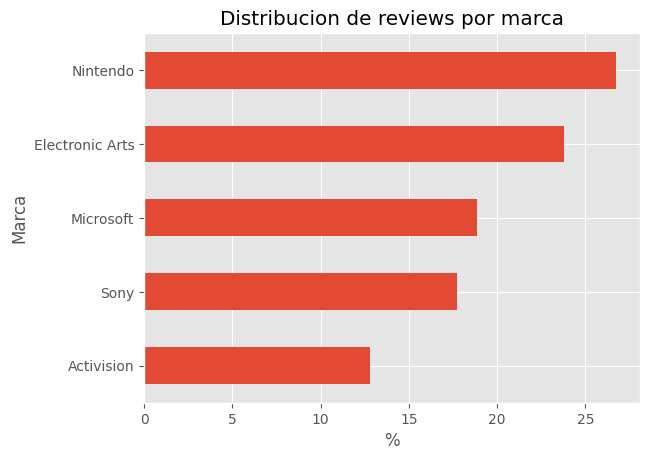

In [17]:
# Se inspecciona el numero de reviews por marca
(data["brand"].value_counts(True) * 100).sort_values()\
    .plot(kind="barh", title="Distribucion de reviews por marca", xlabel="%", ylabel="Marca")

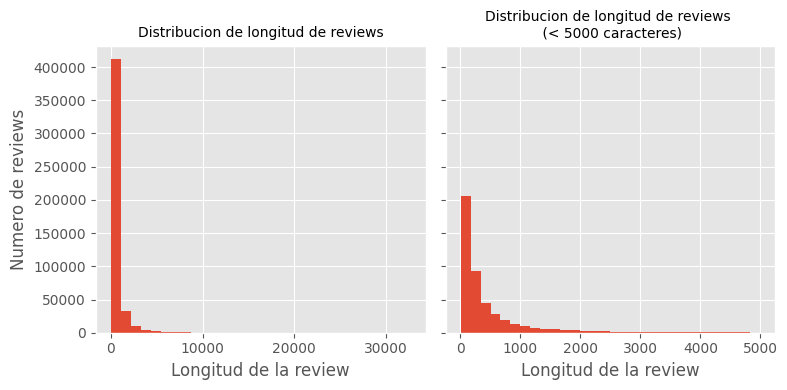

In [18]:
# Se inspecciona la distribucion de la longitud de los reviews
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
data["review"].str.len().plot(kind="hist", bins=30, ax=ax[0])
data[data["review"].str.len() <= 5000]["review"].str.len().plot(kind="hist", bins=30, ax=ax[1])
ax[0].set_title("Distribucion de longitud de reviews", fontsize=10)
ax[1].set_title("Distribucion de longitud de reviews \n (< 5000 caracteres)", fontsize=10)
ax[0].set_ylabel("Numero de reviews")
ax[0].set_xlabel("Longitud de la review")
ax[1].set_xlabel("Longitud de la review")
fig.tight_layout()

In [19]:
# Estadisticas descriptivas de la longitud de las reviews
data["review"].str.len().describe().to_frame().round(2)

,review
count,464291.00
mean,502.83
std,928.24
min,1.00
25%,104.00
50%,199.00
75%,515.00
max,32721.00


Text(0.5, 1.0, 'Disitrbucion de longitud de reviews por marca\n (<= 1000)')

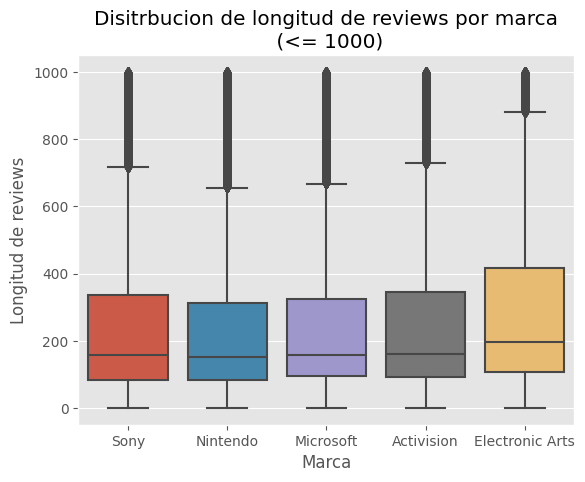

In [20]:
# Se inspecciona la longitud de reviews por marca
data["longitud_rev"] = data["review"].str.len()
sns.boxplot(data=data[data["longitud_rev"] <= 1000], y="longitud_rev", x="brand")
plt.xlabel("Marca")
plt.ylabel("Longitud de reviews")
plt.title("Disitrbucion de longitud de reviews por marca\n (<= 1000)")

#### Preprocesamiento de datos

In [21]:
# Se quitan nuevas lineas y espacios extras
data["review"] = data["review"].str.replace('\s+', ' ', regex=True).str.strip()

In [22]:
# Se pasan las reviews a minuscula
data["review"] = data["review"].str.lower()

In [23]:
# Se quitan acentos
data["review"] = [unidecode(val) for val in data["review"]]

## Procesamiento de Lenguaje Natural - Reviews

In [28]:
# Se crea un Dataset de huggingface para agilizar los procesos de inferencia
hf_data = Dataset.from_pandas(data, preserve_index=False)
hf_data

Dataset({
    features: ['review', 'brand', 'first_category_item', 'longitud_rev'],
    num_rows: 464291
})

### Analisis de sentimientos

In [29]:
# Se crea un pipeline de analisis de sentimientos
SENTIMENT_ANALYSIS_MODEL_NAME = "finiteautomata/bertweet-base-sentiment-analysis"

pipe = pipeline(
    "sentiment-analysis",
    model=SENTIMENT_ANALYSIS_MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    batch_size=128
)

In [30]:
%%time
# Se usa el modelo para obtener el sentimiento de cada review
sentimiento = []
for out in tqdm(pipe(KeyDataset(hf_data, "review"), truncation=True), total=len(hf_data)):
    sentimiento.append(out["label"])

100%|██████████| 464291/464291 [10:03<00:00, 769.52it/s]

CPU times: user 9min 58s, sys: 7.44 s, total: 10min 5s
Wall time: 10min 3s


In [31]:
# Guardamos el sentimiento en el dataframe original
data["sentimiento"] = sentimiento

Text(0.5, 1.0, 'Proporcion de sentimiento de las reviews por marca')

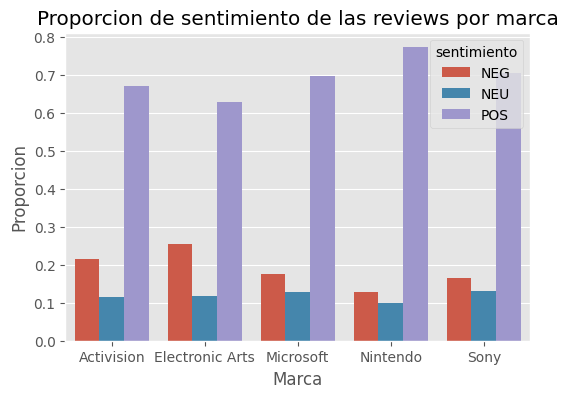

In [32]:
# Se inspeccionan el numero de reviews de cada clase
grouped = data.groupby(["brand", "sentimiento"]).size().reset_index(name="count")
total = data.groupby("brand").size().reset_index(name="total")
merged = pd.merge(grouped, total, on="brand")
merged["proportion"] = merged["count"] / merged["total"]

plt.figure(figsize=(6, 4))
sns.barplot(data=merged, x="brand", y="proportion", hue="sentimiento")
plt.ylabel("Proporcion")
plt.xlabel("Marca")
plt.title("Proporcion de sentimiento de las reviews por marca")

In [33]:
# Guardamos datos de sentimiento negativo para obtener embeddings
data_negativa = data.copy()[data["sentimiento"] == "NEG"].reset_index(drop=True)
print(f"Filas: [{data_negativa.shape[0]:,}]")
print(f"Columnas: [{data_negativa.shape[1]}]")

Filas: [85,823]
Columnas: [5]


In [34]:
# Distribucion de reviews negativas por marca
data_negativa["brand"].value_counts(True)

Electronic Arts    0.329259
Nintendo           0.184927
Microsoft          0.179323
Sony               0.157289
Activision         0.149202
Name: brand, dtype: float64

### Embeddings

In [36]:
# Se carga el modelo
EMBEDDING_MODEL_NAME = "thenlper/gte-large"
model = SentenceTransformer(
    model_name_or_path=EMBEDDING_MODEL_NAME,
    device="cuda"
)

In [37]:
%%time
# Se utiliza el modelo para obtener los embeddings de los reviews y guardarlos en  un tensor
embeddings = model.encode(
    sentences=data_negativa["review"].to_numpy(),
    batch_size=128,
    device="cuda",
    convert_to_tensor=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/671 [00:00<?, ?it/s]

CPU times: user 8min 51s, sys: 321 ms, total: 8min 51s
Wall time: 8min 51s


In [38]:
# Se inspeccionan los embeddings
print(embeddings.shape)
print(type(embeddings))
embeddings[:5]

torch.Size([85823, 1024])
<class 'torch.Tensor'>


tensor([[ 0.0276, -0.0011, -0.0100,  ..., -0.0360, -0.0100, -0.0180],
        [-0.0244,  0.0133, -0.0296,  ..., -0.0317,  0.0067, -0.0129],
        [ 0.0055,  0.0073,  0.0142,  ..., -0.0159,  0.0145, -0.0233],
        [ 0.0064,  0.0132, -0.0109,  ...,  0.0018,  0.0312, -0.0024],
        [ 0.0389,  0.0119, -0.0001,  ..., -0.0195,  0.0077, -0.0332]],
       device='cuda:0')

In [50]:
data_negativa_con_embeddings = pd.concat([data_negativa, pd.DataFrame(embeddings.cpu().numpy())], axis=1)
data_negativa_con_embeddings.columns = [str(col) for col in data_negativa_con_embeddings.columns]
data_negativa_con_embeddings.to_parquet("data.parquet", index=False)